# Data Analysis
In this notebook, we will work on analyzing the JSON data files we created from the previous step. Goal is to perform data analysis from the pageviews data generated from `data_acquisition.ipynb` and graph specific subsets of the data as a timeseries.

What we'll be doing - We'll take a look at the data and make three different kinds of graphs :-
1. We'll show the articles that got the most and the least page views. We'll see how their popularity changed over time, both on computers and phones.
2. We'll pick the 10 articles that got the most page views at once. We'll see when they were most popular, whether people saw them on computers or phones.
3. We'll find the 10 articles that we have the least data for. We'll check if it's different for computers and phones.



## Setup and loading the necessary packages
Note - this analysis was done in Google Colab, which is a Jupyter Notebook setup that runs in cloud. It gets the data files from your Google Drive, for which it requires the below snipped works by making the data files available in Google Drive.

In [1]:
# Mount the drive to load the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Moving to the folder where our data is located
%cd 'drive/MyDrive/data 512'

/content/drive/MyDrive/data 512


In [3]:
# These are standard python modules
import json
from datetime import datetime

# The 'matplotlib' and 'python' modules are not standard Python modules.
# You will need to install these with pip/pip3 if you do not already have it
import pandas as pd
import matplotlib.pyplot as plt

We load the two datasets that we created in the previous step, for our analysis.

In [4]:
# Function to load the JSON data
def load_json(filename):
    """Loads a JSON file from the given filename.

    Args:
        filename (str): The name of the JSON file to load.

    Returns:
        dict: The contents of the JSON file as a Python dictionary.
    """
    with open(filename, 'r') as f:
        return json.load(f)

mobile_data = load_json('rare-disease_monthly_mobile_201501-202409.json')
desktop_data = load_json('rare-disease_monthly_desktop_201501-202409.json')

## 1. Maximum Average and Minimum Average
Here, we look at the time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. The graph has four lines (max desktop, min desktop, max mobile, min mobile)

In [5]:
# Processes the data and calculate averages, also stores the datetime in a python-friendly format
def process_data(data):
    """Processes the given data by calculating average views and creating a time series.

    Args:
        data (dict): A dictionary where keys are disease names and values are lists of entries.
            Each entry is a dictionary with 'views' and 'timestamp' keys.

    Returns:
        dict: A dictionary where keys are disease names and values are dictionaries containing
            'avg_views' (average views) and 'time_series' (a dictionary mapping timestamps to views).
    """
    processed = {}
    for disease, entries in data.items():
        views = [entry['views'] for entry in entries]
        avg_views = sum(views) / len(views)
        processed[disease] = {
            'avg_views': avg_views,
            'time_series': {datetime.strptime(entry['timestamp'], '%Y%m%d%H'): entry['views'] for entry in entries}
        }
    return processed

mobile_processed = process_data(mobile_data)
desktop_processed = process_data(desktop_data)

In [6]:
# Find max and min average diseases
def find_min_and_max(data):
    """Finds the disease with the minimum and maximum average views.

    Args:
        data (dict): A dictionary containing processed disease data.

    Returns:
        tuple: A tuple containing the disease with the minimum average views and the disease with the maximum average views.
    """
    sorted_data = sorted(data.items(), key=lambda x: x[1]['avg_views'])
    return sorted_data[0][0], sorted_data[-1][0]

min_mobile, max_mobile = find_min_and_max(mobile_processed)
min_desktop, max_desktop = find_min_and_max(desktop_processed)

In [7]:
# Create time series for plotting each of the min/max of mobile/desktop data
def create_time_series(data, disease):
    """Creates a pandas Series giving us the time series of views for a given disease.

    Args:
        data (dict): A dictionary containing processed disease data.
        disease (str): The name of the disease for which to create the time series.

    Returns:
        pandas.Series: A Series indexed by timestamps, with values representing the number of views.
    """
    return pd.Series(data[disease]['time_series']).sort_index()

max_desktop_series = create_time_series(desktop_processed, max_desktop)
min_desktop_series = create_time_series(desktop_processed, min_desktop)
max_mobile_series = create_time_series(mobile_processed, max_mobile)
min_mobile_series = create_time_series(mobile_processed, min_mobile)

When we plot the data we calculated above, we get a line graph with four lines (max desktop, min desktop, max mobile, min mobile).

From the plot, we can see that -
* For both desktop and mobile, Black Death disease has the maximum page requests.
* For both desktop and mobile, Filippi Syndrome has the minimum page requests.

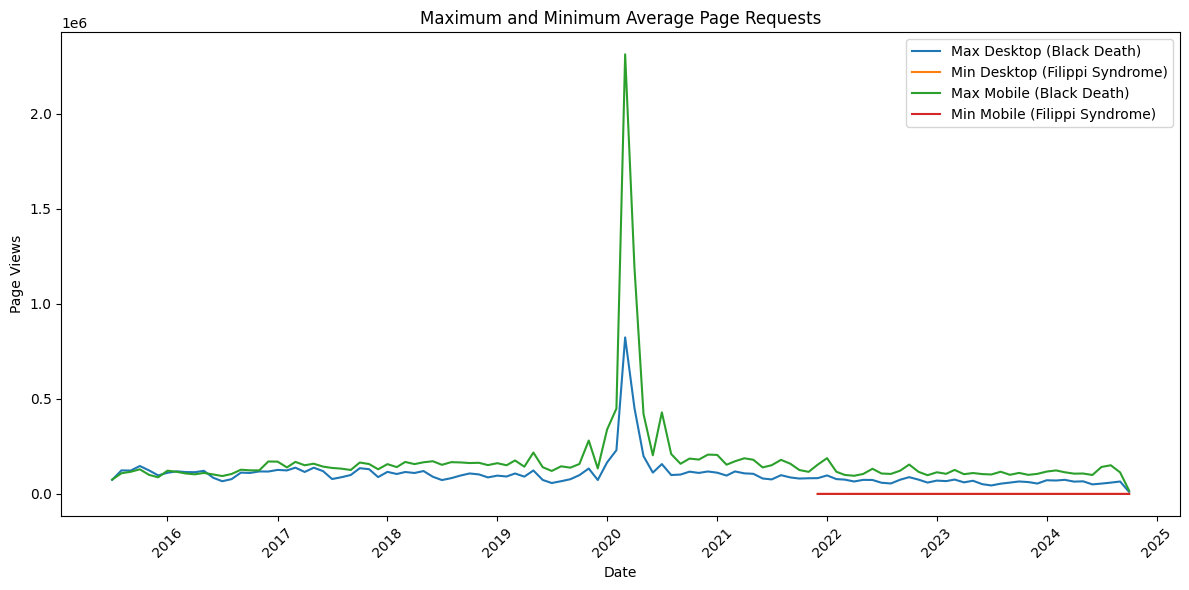

In [8]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(max_desktop_series.index, max_desktop_series.values, label=f'Max Desktop ({max_desktop})')
plt.plot(min_desktop_series.index, min_desktop_series.values, label=f'Min Desktop ({min_desktop})')
plt.plot(max_mobile_series.index, max_mobile_series.values, label=f'Max Mobile ({max_mobile})')
plt.plot(min_mobile_series.index, min_mobile_series.values, label=f'Min Mobile ({min_mobile})')

plt.title('Maximum and Minimum Average Page Requests')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('pageview_analysis.png')
plt.show()

## 2. Top 10 Peak Page Views
Here, we look into the top 10 article pages by largest (peak) page views over the entire time series by access type. We first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values.

In [9]:
# Process data and find peak views
def process_data_peak(data):
    """Processes the given data by finding the peak views and date for each disease.

    Args:
        data (dict): A dictionary where keys are disease names and values are lists of entries.
            Each entry is a dictionary with 'views' and 'timestamp' as keys.

    Returns:
        dict: A dictionary where keys are disease names and values are dictionaries having
            'peak_views' (the maximum number of views), 'peak_date' (the date of peak views),
            and 'time_series' (a dictionary mapping timestamps to views).
    """
    processed = {}
    for disease, entries in data.items():
        peak_entry = max(entries, key=lambda x: x['views'])
        processed[disease] = {
            'peak_views': peak_entry['views'],
            'peak_date': datetime.strptime(peak_entry['timestamp'], '%Y%m%d%H'),
            'time_series': {datetime.strptime(entry['timestamp'], '%Y%m%d%H'): entry['views'] for entry in entries}
        }
    return processed

mobile_processed = process_data_peak(mobile_data)
desktop_processed = process_data_peak(desktop_data)

In [10]:
# Find top 10 peak diseases
def find_top_10(data):
    """Finds the top 10 diseases based on their peak views.

    Args:
        data (dict): A dictionary containing processed disease data with peak views.

    Returns:
        list: A list of tuples, where each tuple contains the disease name and its corresponding peak views.
    """
    return sorted(data.items(), key=lambda x: x[1]['peak_views'], reverse=True)[:10]

top_10_mobile = find_top_10(mobile_processed)
top_10_desktop = find_top_10(desktop_processed)

Our graph contains the top 10 for desktop and top 10 for mobile access (20 lines). We use dashed lines for desktop and solid lines for mobile, so that it is easier to distinguish both easily.

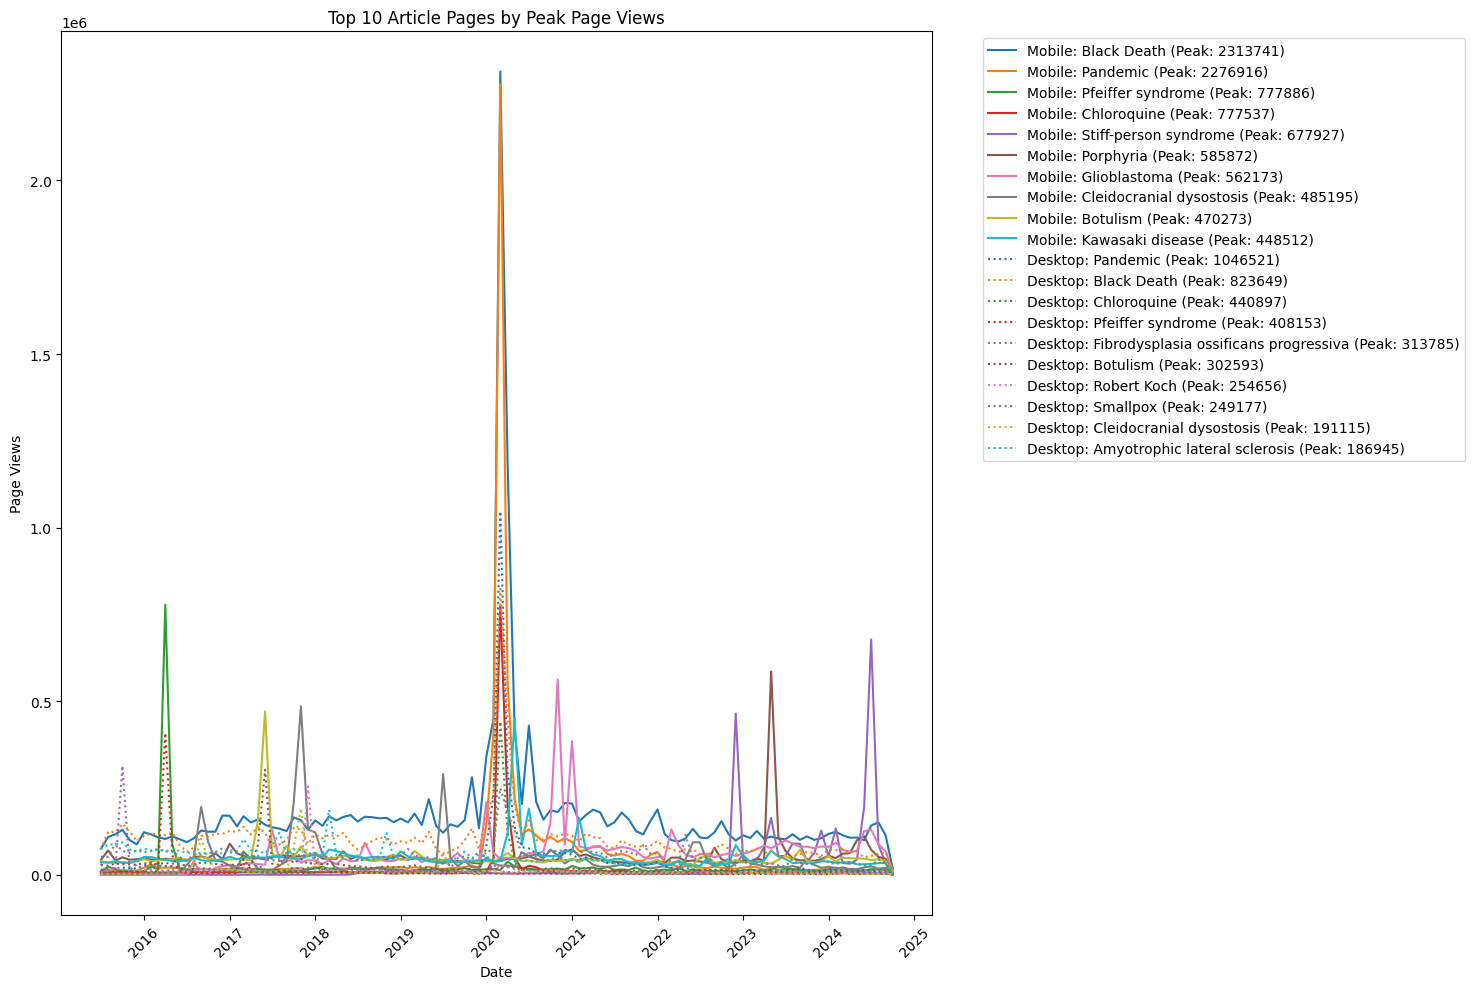

In [11]:
# Create time series for plotting
def create_time_series(data, disease):
    """
    Create a time series from the specified disease data.

    Parameters:
    data (dict): A dictionary containing disease data with time series.
    disease (str): The key for the specific disease to extract the time series.

    Returns:
    pd.Series: A sorted pandas Series of the time series data for the specified disease.
    """
    return pd.Series(data[disease]['time_series']).sort_index()

# Plotting
plt.figure(figsize=(15, 10))

# Plot mobile data
for disease, info in top_10_mobile:
    series = create_time_series(mobile_processed, disease)
    plt.plot(series.index, series.values, label=f'Mobile: {disease} (Peak: {info["peak_views"]})')

# Plot desktop data
for disease, info in top_10_desktop:
    series = create_time_series(desktop_processed, disease)
    plt.plot(series.index, series.values, label=f'Desktop: {disease} (Peak: {info["peak_views"]})', linestyle='dotted')

plt.title('Top 10 Article Pages by Peak Page Views')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_10_peak_pageviews.png', bbox_inches='tight')
plt.show()

The graph clearly shows that most of the significant peaks in article views are on mobile devices, indicated by the solid lines. The articles of "Black Death" and "Pandemic" rank as the top two in views for both desktop and mobile. While "Pandemic" has the highest view count on desktops, "Black Death" takes the lead for mobile views in a given month.

## 3. Fewest months of data
Here, we look into the fewest months of available data. Since these will be relatively short time series, some may only have one month of data.
So we show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

In [12]:
# Process data and count months
def process_data_count_months(data):
    """
    Process disease data to count months and create a time series.

    Parameters:
    data (dict): A dictionary where each key is a disease and the value
                 is a list of entries containing 'timestamp' and 'views'.

    Returns:
    dict: A dictionary where each key is a disease and the value is another
          dictionary with the count of months and a time series mapping
          timestamps to views.
    """
    processed = {}
    for disease, entries in data.items():
        months_count = len(entries)
        time_series = {datetime.strptime(entry['timestamp'], '%Y%m%d%H'): entry['views'] for entry in entries}
        processed[disease] = {
            'months_count': months_count,
            'time_series': time_series
        }
    return processed

mobile_processed = process_data_count_months(mobile_data)
desktop_processed = process_data_count_months(desktop_data)

In [13]:
# Find 10 diseases with fewest months
def find_fewest_months(data):
    """
    Find the top 10 diseases with the fewest months of data.

    Parameters:
    data (dict): A dictionary where each key is a disease and the value
                 is a dictionary containing a 'months_count' field.

    Returns:
    list: A sorted list of tuples, each containing a disease and its
          associated data, limited to the 10 diseases with the fewest months.
    """
    return sorted(data.items(), key=lambda x: x[1]['months_count'])[:10]

fewest_months_mobile = find_fewest_months(mobile_processed)
fewest_months_desktop = find_fewest_months(desktop_processed)

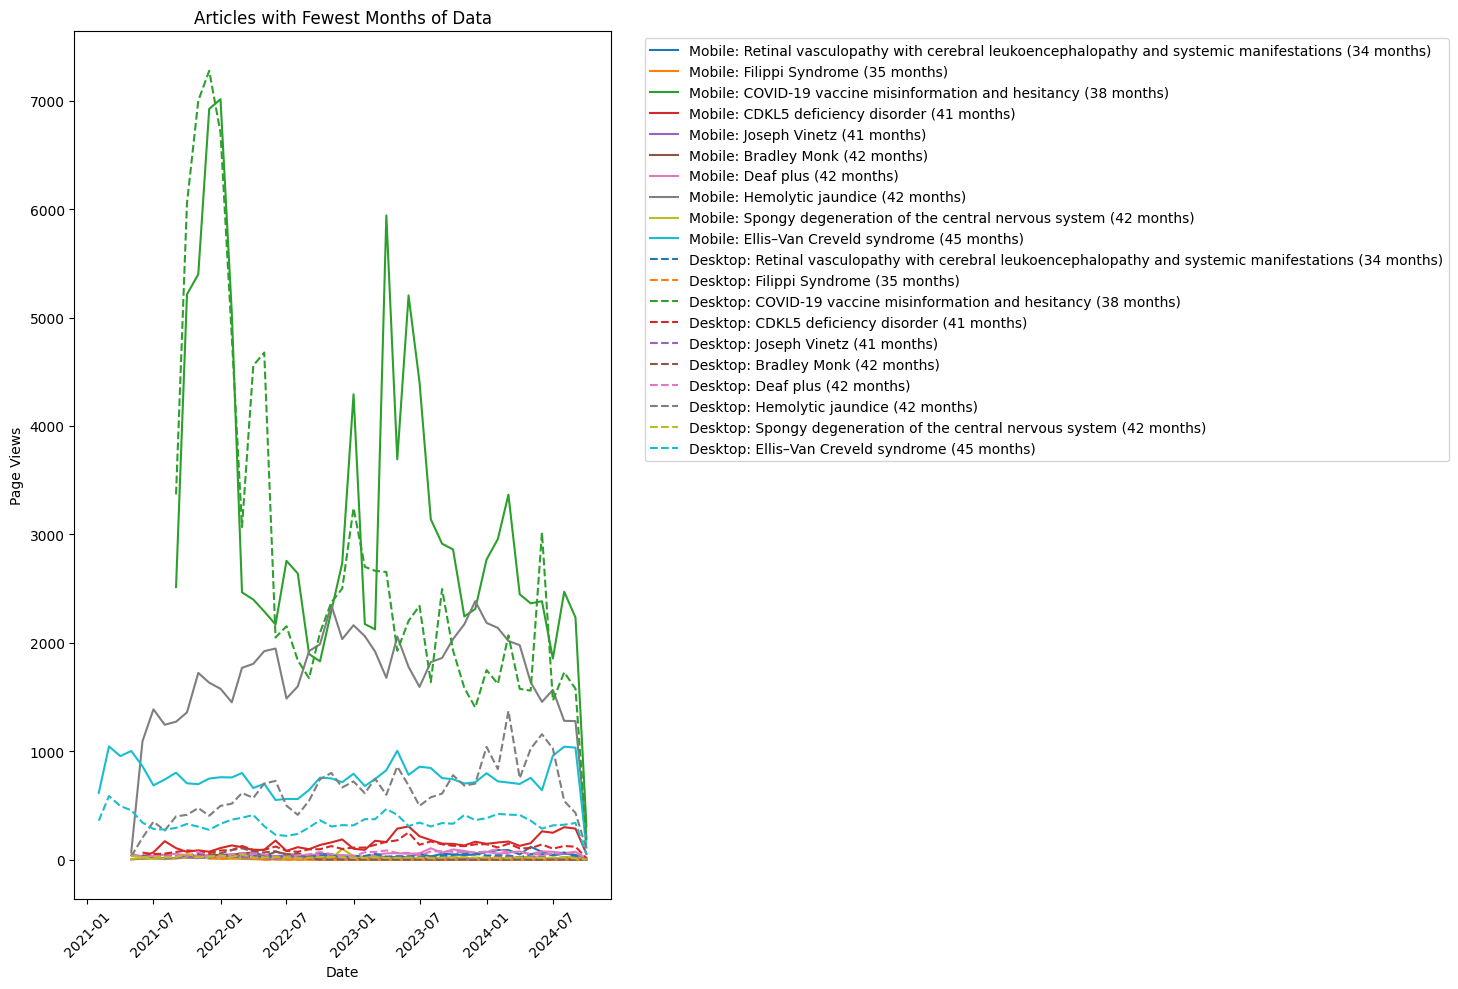

In [14]:
# Create time series for plotting
def create_time_series(data, disease):
    """
    Create a time series from the specified disease data.

    Parameters:
    data (dict): A dictionary containing disease data with time series.
    disease (str): The key for the specific disease to extract the time series.

    Returns:
    pd.Series: A sorted pandas Series of the time series data for the specified disease.
    """
    return pd.Series(data[disease]['time_series']).sort_index()

# Plotting
plt.figure(figsize=(15, 10))

# Plot mobile data
for i, (disease, info) in enumerate(fewest_months_mobile):
    series = create_time_series(mobile_processed, disease)
    plt.plot(series.index, series.values, label=f'Mobile: {disease} ({info["months_count"]} months)', linestyle='-')

# Plot desktop data
for i, (disease, info) in enumerate(fewest_months_desktop):
    series = create_time_series(desktop_processed, disease)
    plt.plot(series.index, series.values, label=f'Desktop: {disease} ({info["months_count"]} months)', linestyle='--')

plt.title('Articles with Fewest Months of Data')
plt.xlabel('Date')
plt.ylabel('Page Views')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fewest_months_data.png', bbox_inches='tight')
plt.show()

The graph shows that articles with data for fewer months tend to have relatively low view counts, except for those discussing "COVID-19 vaccine misinformation and hesitancy" and "Hemolytic jaundice." Even in these cases, the view counts are quite small compared to earlier graphs, where views reached into the millions. What’s particularly interesting is the viewing patterns for the article on COVID-19 vaccine misinformation, which differ noticeably between desktop and mobile users, especially in the early months of 2023. To fully understand this trend, we might need to dig deeper into the subject matter.